# Multiclass Text Classification with TF-IDF

We work with a sample from the actual dataset containing consumer complaints. The full dataset could be found [here](https://catalog.data.gov/dataset/consumer-complaint-database).

In [1]:
from google.colab import drive
drive.mount('/content/drive/')


Mounted at /content/drive/


In [15]:
import pandas as pd #Data manipulation
import numpy as np
from scipy.stats import randint
import seaborn as sns # used for plot interactive graph.
import matplotlib.pyplot as plt
import seaborn as sns
from io import StringIO
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics

In [16]:
df=pd.read_csv('/content/drive/MyDrive/movies.csv')

### Exploration and Preprocessing

In [17]:
df.head(10) #this way you can display columns as rows.

Unnamed: 0        genre                                        description
0           0        drama  Listening in to a conversation between his doc...
1           1     thriller  A brother and sister with a past incestuous re...
2           2        adult  As the bus empties the students for their fiel...
3           3        drama  To help their unemployed father make ends meet...
4           4        drama  The film's title refers not only to the un-rec...
5           5  documentary  Quality Control consists of a series of 16mm s...
6           6       comedy  In tough economic times Max and Joey have all ...
7           7        crime  Ron Petrie (Keanu Reeves) is a troubled teen w...
8           8   reality-tv  A sudden calamitous event, causing great loss ...
9           9       horror  Four high school students embark on a terrifyi...

Let's remove some information that we do not need and build another dataframe that contains "Product" and "Consumer complaint narrative" (renamed as "Complaint").

In [18]:
# Create a new dataframe with two columns
df1 = df[['genre','description']].copy()

# Remove missing values (NaN)
df1 = df1[pd.notnull(df1['description'])]

# Renaming second column for a simpler name
#df1.columns = ['Product', 'Complaint']

df1.shape

(54214, 2)

In [19]:
# Percentage of complaints that had text field
total = df1['description'].notnull().sum()
round((total/len(df)*100),1)

100.0

In [20]:
pd.DataFrame(df.genre.unique()).values

array([['drama'],
       ['thriller'],
       ['adult'],
       ['documentary'],
       ['comedy'],
       ['crime'],
       ['reality-tv'],
       ['horror'],
       ['sport'],
       ['animation'],
       ['action'],
       ['fantasy'],
       ['short'],
       ['sci-fi'],
       ['music'],
       ['adventure'],
       ['talk-show'],
       ['western'],
       ['family'],
       ['mystery'],
       ['history'],
       ['news'],
       ['biography'],
       ['romance'],
       ['game-show'],
       ['musical'],
       ['war']], dtype=object)

There are 17 different classes or categories that we can use as out target variable. However some classes contain smaller ones. For example, "Credit card or prepaid card" contains "Credit card" and "Prepaid card". Let us rename some categories to avoid potential conflicts.

In [21]:
# let's work with a smaller smaple of the data to speed things up
df2 = df1.sample(30000, random_state=2).copy()

In [22]:
pd.DataFrame(df2.genre.unique())
df2.genre.value_counts()

drama          7489
documentary    7290
comedy         4084
short          2828
horror         1215
thriller        862
action          746
western         572
reality-tv      496
adventure       433
family          429
music           394
romance         358
adult           336
sci-fi          335
animation       287
crime           281
sport           250
talk-show       207
fantasy         194
mystery         188
biography       152
musical         143
history         142
game-show       112
news            107
war              70
Name: genre, dtype: int64

In [23]:
# Get the count of each genre
genre_counts = df2.genre.value_counts()

# Identify genres with count less than 10
genres_to_replace = genre_counts[genre_counts < 200].index

# Replace these genres with 'other'
df2.loc[df2.genre.isin(genres_to_replace), 'genre'] = 'other'

# Check the result
print(df2.genre.value_counts())
print(df2)

drama          7489
documentary    7290
comedy         4084
short          2828
horror         1215
other          1108
thriller        862
action          746
western         572
reality-tv      496
adventure       433
family          429
music           394
romance         358
adult           336
sci-fi          335
animation       287
crime           281
sport           250
talk-show       207
Name: genre, dtype: int64
             genre                                        description
49672        drama  A bizarre couple and their seventeen-year-old ...
48949        short  The world has been taken over by The Unknown. ...
15204        drama  The drama tells the story about a variety of e...
41474       comedy  Petr Vok ('Martin Ruzek' (qv)) changes entirel...
39976       horror  Jeremy moves his family consisting of his son ...
...            ...                                                ...
8401         drama  Chelsea (Sasha Grey) is a high-priced $2,000-a...
48178  documen

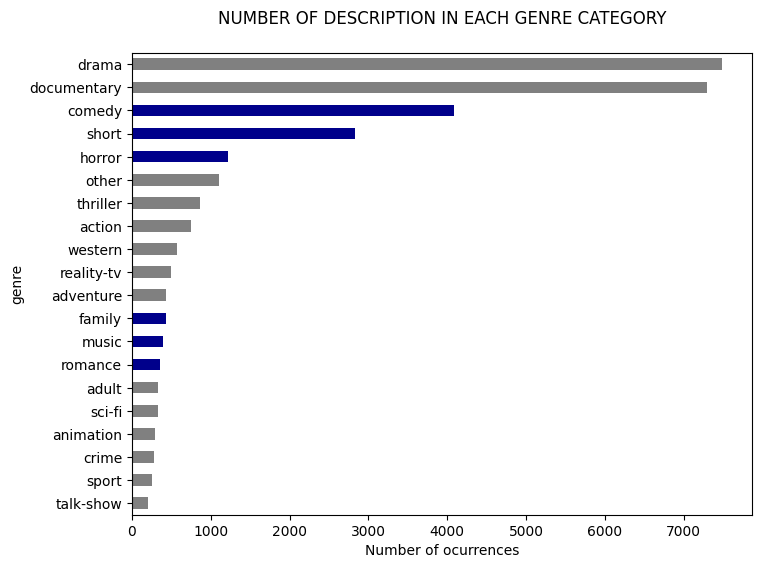

In [24]:
fig = plt.figure(figsize=(8,6))
colors = ['grey','grey','grey','grey','grey',
    'grey','darkblue','darkblue','darkblue']
df2.groupby('genre').description.count().sort_values().plot.barh(
    ylim=0, color=colors, title= 'NUMBER OF DESCRIPTION IN EACH GENRE CATEGORY\n')
plt.xlabel('Number of ocurrences', fontsize = 10);

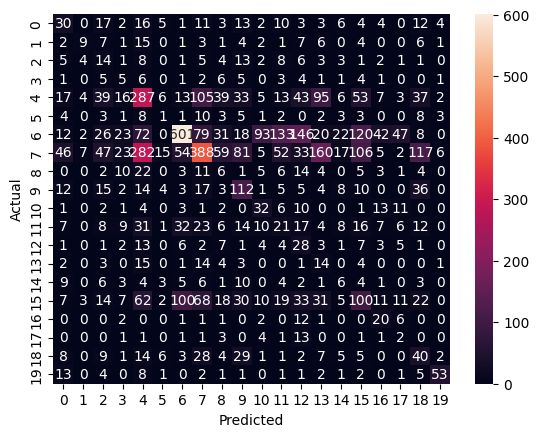

In [25]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from collections import Counter
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt



# Basic text preprocessing
def preprocess_text(text):
    text = text.lower().split()
    return text

df2['description'] = df2['description'].apply(preprocess_text)

# Encode labels
label_encoder = LabelEncoder()
df2['genre'] = label_encoder.fit_transform(df2['genre'])

# Create vocabulary
word_counts = Counter(word for description in df2['description'] for word in description)
vocab = sorted(word_counts, key=word_counts.get, reverse=True)
vocab_to_int = {word: ii for ii, word in enumerate(vocab, 1)}

# Encode reviews
def encode_reviews(reviews, vocab_to_int):
    encoded = []
    for review in reviews:
        encoded.append([vocab_to_int[word] for word in review if word in vocab_to_int])
    return encoded

df2['encoded_description'] = encode_reviews(df2['description'], vocab_to_int)

# Padding sequences
def pad_features(reviews, seq_length):
    features = np.zeros((len(reviews), seq_length), dtype=int)
    for i, review in enumerate(reviews):
        if len(review) != 0:
            features[i, -len(review):] = np.array(review)[:seq_length]
    return features

seq_length = 200
features = pad_features(df2['encoded_description'], seq_length)

# Split data
X_train, X_test, y_train, y_test = train_test_split(features, df2['genre'].values, test_size=0.2)

# Dataloaders
batch_size = 50
train_data = torch.utils.data.TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
test_data = torch.utils.data.TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size)

# Define GRU Model
class GRUModel(nn.Module):
    def __init__(self, vocab_size, output_size, embedding_dim, hidden_dim, n_layers, drop_prob=0.5):
        super(GRUModel, self).__init__()
        self.output_size = output_size
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.gru = nn.GRU(embedding_dim, hidden_dim, n_layers, batch_first=True, dropout=drop_prob)
        self.fc = nn.Linear(hidden_dim, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x, hidden):
        x = x.long()
        embeds = self.embedding(x)
        gru_out, hidden = self.gru(embeds, hidden)
        gru_out = gru_out[:, -1]
        out = self.fc(gru_out)
        soft_out = self.softmax(out)

        return soft_out, hidden

    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = weight.new(self.n_layers, batch_size, self.hidden_dim).zero_()
        return hidden

# Parameters
vocab_size = len(vocab_to_int) + 1
output_size = len(df2['genre'].unique())
embedding_dim = 400
hidden_dim = 256
n_layers = 2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = GRUModel(vocab_size, output_size, embedding_dim, hidden_dim, n_layers)
model.to(device)

# Calculate class weights
class_weights = [df2['genre'].value_counts().max() / df2['genre'].value_counts()[i] for i in range(output_size)]
class_weights = torch.FloatTensor(class_weights).to(device)

# Loss and Optimizer
criterion = nn.NLLLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 4
clip = 5

for epoch in range(epochs):
    h = model.init_hidden(batch_size)

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        h = h.data
        model.zero_grad()
        output, h = model(inputs, h)
        loss = criterion(output, labels)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()

# Generate Confusion Matrix
y_pred = []
y_true = []

model.eval()
h = model.init_hidden(batch_size)

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        h = h.data
        output, h = model(inputs, h)
        pred = torch.argmax(output, dim=1)
        y_pred.extend(pred.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

# Plotting the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


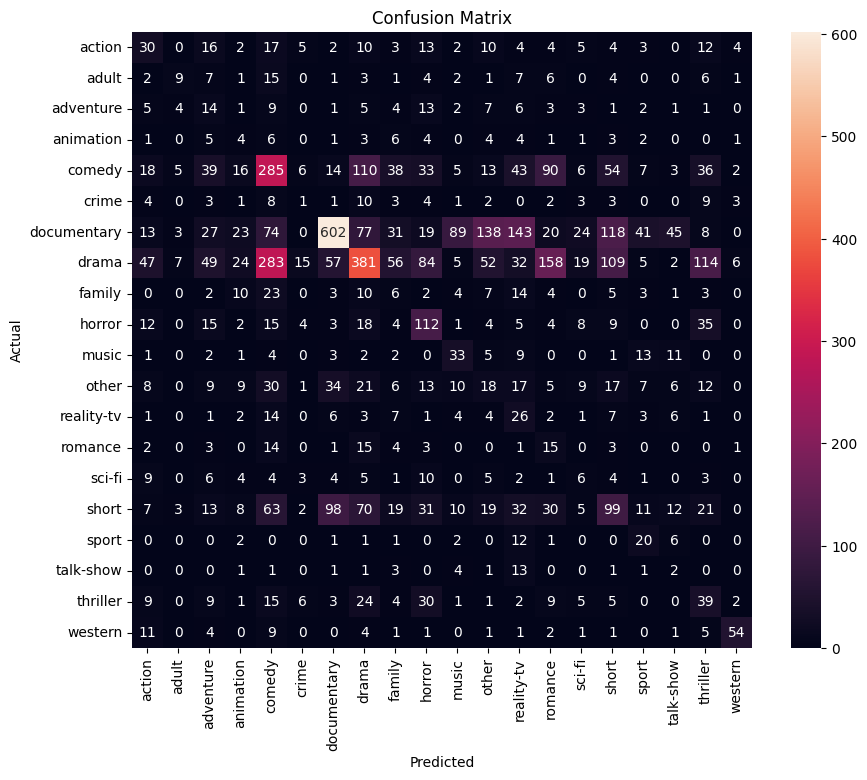

In [26]:

# Generate Confusion Matrix
y_pred = []
y_true = []

model.eval()
h = model.init_hidden(batch_size)

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        h = h.data
        output, h = model(inputs, h)
        pred = torch.argmax(output, dim=1)
        y_pred.extend(pred.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

# Convert numeric labels to original genre labels
y_true_labels = label_encoder.inverse_transform(y_true)
y_pred_labels = label_encoder.inverse_transform(y_pred)

# Confusion matrix with real labels
conf_matrix = confusion_matrix(y_true_labels, y_pred_labels)
labels = label_encoder.classes_

# Plotting the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=labels, yticklabels=labels)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()


Accuracy: 29.27%


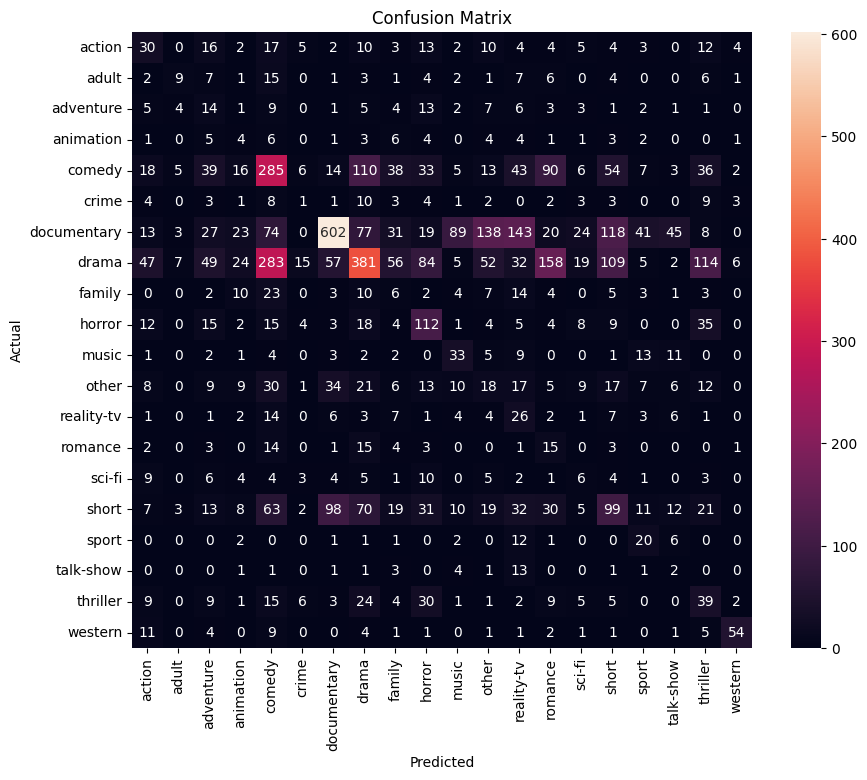

In [27]:
# Calculate accuracy
accuracy = np.trace(conf_matrix) / np.sum(conf_matrix)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Plotting the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=labels, yticklabels=labels)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()
